# Project 9: Partial Correlations and Directed Acyclic Graphs

The OLS regression is a powerful tool. So powerful, in fact, that you would have trouble mastering the tool in the period of just a few years. This is not to say that you could not master a particular application with OLS, however, there are many applications.

Statisticians have, historically, not been fond of making causal claims using statistics aside from the causal inferences generated from randomized control trials. In recent decades, however, the statisticians behind the causal inference revolution have move precisely in this direction. In this lesson, we will consider a particular manifestation of the causal inference revolution: Directed Acyclic Graphs (DAGs). DAGs provide a causal map, creating a causal skeleton detected using computational methods.

In order to understand DAGs, we must first take review the concept of partial correlation. A partial correlation is a correlation that controls for changes in a set of control variables. Fortunately, we can calculate partial correlations using a set of ordinary least squares regression. Suppose that we want to calculate the partial correlation of variables $Q$ and $X$ controlling for $Y$ and $Z$. This would be accomplished by running four regressions, one for each variable. Across the set of regressions, each variable of interest is treated as the endogenous variable with the remaining variables be treated as exogensous variables. We can envision a vector of y vectors:

$y = [y_j, y_{j+1}, . . . , y_{n-1}, y_n]$

For every $y_j$, we will run a regression where the remaining vectors comprise the matrix X, which includes a vector of 1s: 

$y_j = \beta_0 +\sum^{m}_{j=1}\beta_j x_{i,j} + \epsilon_j$

To aid our understanding of this process, we will create 5 variables using a random number generator. We will first calculate partial correlations among these variables. Then we will generate a undirected graph that will form the basis of the directed acyclic graph that we ultimately aim to build. Since we created the variables, we know which variable *causes* another.

In [1]:
import random
import numpy as np
import pandas as pd

length = 100000
cols = ["P", "Q", "X", "Y", "Z"]
mu = 0
sigma = 5


lst_dct = {col:[] for col in cols}
for i in range(length):
    lst_dct["P"].append(25 + np.random.normal(mu, .5 * sigma))
    lst_dct["Q"].append(50 + np.random.normal(mu, sigma))
    lst_dct["X"].append(3 * lst_dct["Q"][-1]  + np.random.normal(mu, sigma ))
    lst_dct["Y"].append(lst_dct["Q"][-1] * -1 +  np.random.normal(mu, sigma))
    lst_dct["Z"].append(
        lst_dct["P"][-1] * 2 +  1.5 * lst_dct["X"][-1] -  lst_dct["Y"][-1] * 2 +  np.random.normal(mu,  sigma))

df = pd.DataFrame(lst_dct)
df

,P,Q,X,Y,Z
0,25.763981,50.383531,154.817580,-52.501916,380.933946
1,27.206440,50.745727,147.598943,-41.967766,357.108431
2,27.289253,50.815116,148.389219,-34.498135,345.170876
3,30.819371,47.534346,144.339268,-52.992742,394.609914
4,26.518508,43.252891,133.016815,-37.699388,319.322523
...,...,...,...,...,...
99995,26.764339,45.197248,137.936915,-39.887776,342.851474
99996,26.390515,53.784425,164.867550,-56.772896,416.847257
99997,27.509861,60.159244,175.599940,-54.165200,427.450507
99998,26.256838,56.503433,175.013129,-57.157594,414.276808


Obviously, these variables are correlated. Variables X, Y, and Z all descend from Q. X and Y are direct descendants of Q whereas Z is a direct descendant of X, Y, and P. We can view some of these correlation in a single plot.

<AxesSubplot:xlabel='Q', ylabel='Z'>

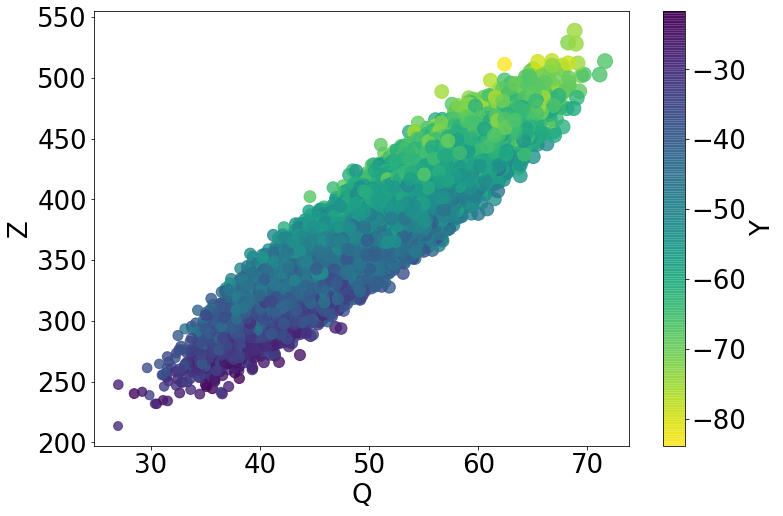

In [2]:
import matplotlib.pyplot as plt
# We can visualize the correlation of these variables on four dimensions:
#     2 dimensions in x-y space, a 3rd dimension using size and a fourth using color
plt.rcParams.update({"font.size":26})
fig, ax = plt.subplots(figsize = (12,8))
df.plot.scatter(x = "Q", y = "Z", c = "Y",s = "X", cmap = "viridis_r",alpha = .8, ax = ax)

In [3]:
df.corr()

,P,Q,X,Y,Z
P,1.000000,-0.001919,-0.000580,0.001393,0.139851
Q,-0.001919,1.000000,0.948289,-0.707360,0.914082
X,-0.000580,0.948289,1.000000,-0.670998,0.934373
Y,0.001393,-0.707360,-0.670998,1.000000,-0.846072
Z,0.139851,0.914082,0.934373,-0.846072,1.000000


# Partial Correlation

All of the variables appear to be correlated. Yet, we should be suspicious of the correlation between $Z$ and $Q$. $Q$ does not cause $Z$ directly. Its causal effect on Z is intermediated by $X$ and $Y$. Likewise, $X$ and $Y$ appear to be strongly correlated, but we know that these variables do not cause one another. They have a common cause.

To calculate correlation between two variables while controlling for the effects of the remaining variables, we calculate the partial correlation. For example, the partial correlation of $Q$ and $X$ is an estimate of the correlation of the two variables controlling for $Y$ and $Z$: $\rho_{QX.YZ}$. 

It is convenient that a partial correlation can be calculated using a set of OLS regressions equal in number to the number of variables, with each serving as the endogenous variable to be estimated by the remaing variables and a constant. We calculate the partial correlation of two variables by calculating the correlation of the error terms from the regressions that estimate $Q$ and $X$ as dependent variables, given the example in the previous paragraph. Thus, in our example, we can calculate partial correlations with up to 5 different OLS equations. If all 5 equations are used, then the partial correlation will control for the remaining 3 variables. As we will see, there may be reason to exclude one or more controls variables.

In [4]:
import statsmodels.api as sm

residuals = {}
for y_var in df.keys():
    X_vars = list(df.keys())
    X_vars.remove(y_var)
    X = df[X_vars]
    # Initial estimate should include constant
    #   This won't be the case we regress the errors
    X["Constant"] = 1
    # pass y_var as list for consistent structure
    y = df[[y_var]]
    model = sm.OLS(y, X)
    results = model.fit()
    residuals[y_var] = results.resid
residuals = pd.DataFrame(residuals)

In [5]:
residuals

,P,Q,X,Y,Z
0,2.328962,-1.167404,4.734461,-3.550627,-7.823822
1,1.752207,2.133729,-0.226228,0.712787,-2.583651
2,1.374062,2.671807,-0.823093,2.887063,-0.902389
3,0.307128,-1.176031,-4.308618,3.075776,10.432006
4,2.895289,-0.999781,4.958672,-2.331040,-8.595988
...,...,...,...,...,...
99995,0.210567,-0.586671,-0.529643,2.124805,2.679667
99996,-0.103919,-0.886096,-0.406517,0.681914,3.204404
99997,1.084718,2.801184,-1.818382,1.479934,0.722886
99998,4.385529,-0.984710,8.657557,-6.158515,-15.085168


The partial correlation is the negative correlation of the residuals generated by the above set of regressions. For all relevant partial correlations ($|pcorr(A,B)| < 1$), we multiply the partial correlation by $-1$. If you like, you can use df.fillna(1) to replace the null values in the diagonal of the dataframe.

In [6]:
residuals.corr()[residuals.corr().abs() < 1].mul(-1).fillna(1).round(2)

,P,Q,X,Y,Z
P,1.00,-0.00,-0.59,0.63,0.71
Q,-0.00,1.00,0.50,-0.14,-0.00
X,-0.59,0.50,1.00,0.75,0.83
Y,0.63,-0.14,0.75,1.00,-0.89
Z,0.71,-0.00,0.83,-0.89,1.00


In [7]:
# !pip install pingouin
import pingouin
df.pcorr().round(2)

,P,Q,X,Y,Z
P,1.00,-0.00,-0.59,0.63,0.71
Q,-0.00,1.00,0.50,-0.14,-0.00
X,-0.59,0.50,1.00,0.75,0.83
Y,0.63,-0.14,0.75,1.00,-0.89
Z,0.71,-0.00,0.83,-0.89,1.00


C:\Users\JLCat\AppData\Roaming\Python\Python38\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.0.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


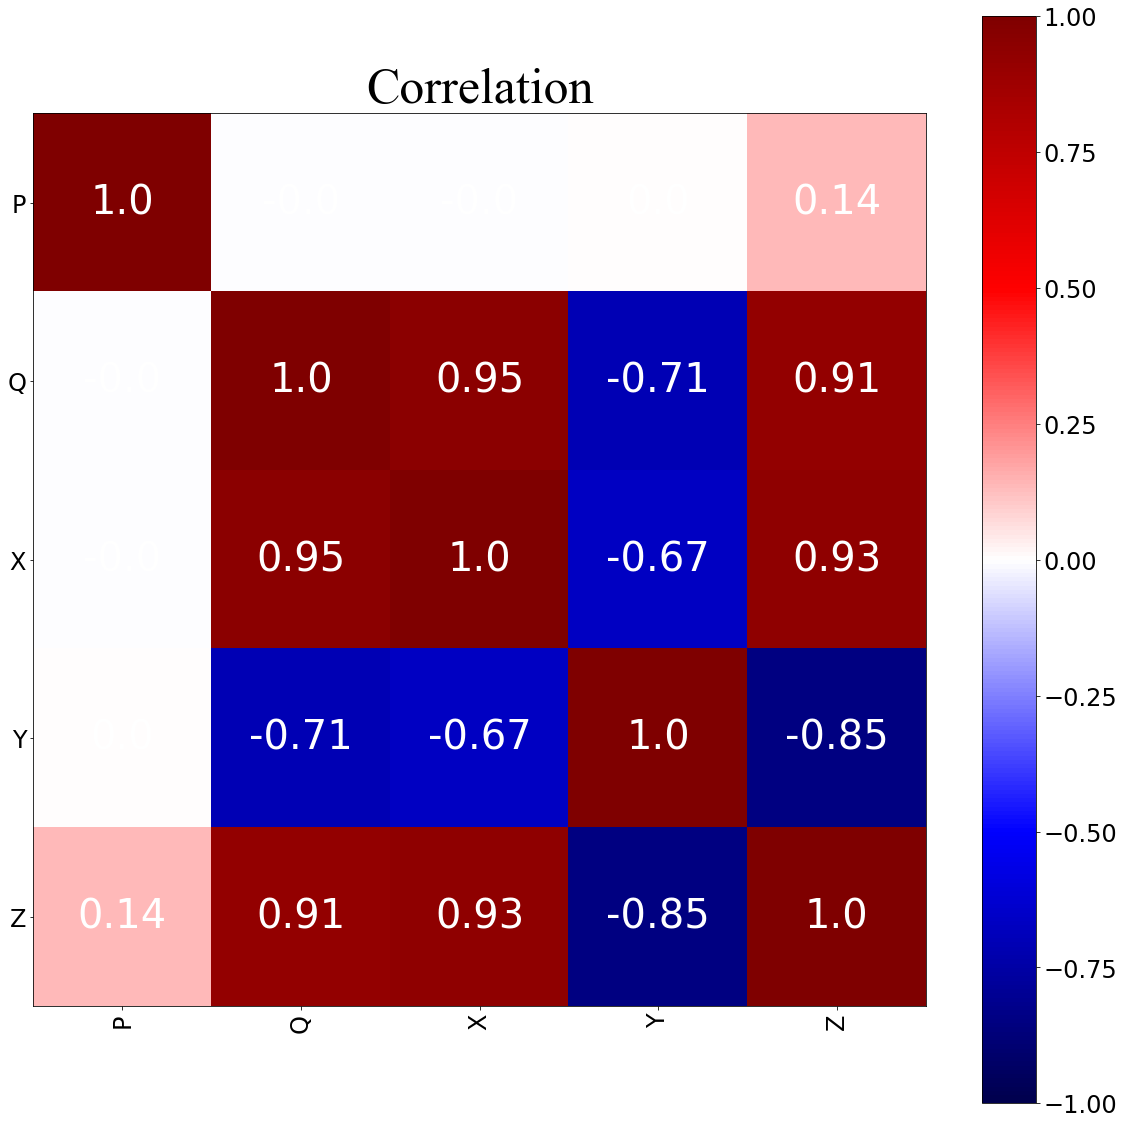

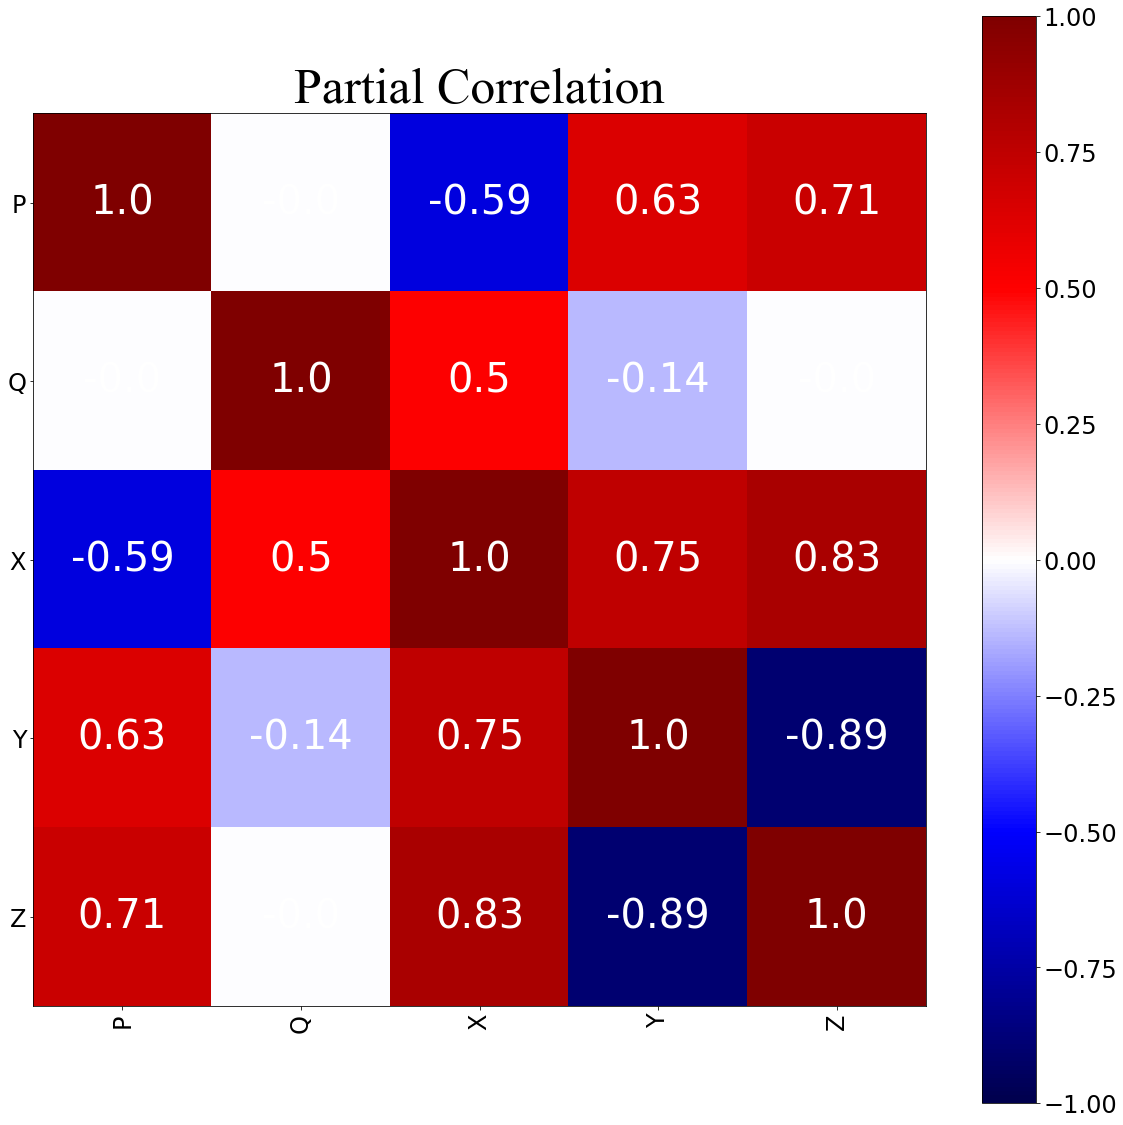

In [8]:
from datlib.plots import *
corr_matrix_heatmap(df.corr(), 
                    save_fig = False, 
                    pp = None, 
                    title = "Correlation")
corr_matrix_heatmap(df.pcorr(), save_fig = False, pp = None, title = "Partial Correlation")

In [9]:
residuals

,P,Q,X,Y,Z
0,2.328962,-1.167404,4.734461,-3.550627,-7.823822
1,1.752207,2.133729,-0.226228,0.712787,-2.583651
2,1.374062,2.671807,-0.823093,2.887063,-0.902389
3,0.307128,-1.176031,-4.308618,3.075776,10.432006
4,2.895289,-0.999781,4.958672,-2.331040,-8.595988
...,...,...,...,...,...
99995,0.210567,-0.586671,-0.529643,2.124805,2.679667
99996,-0.103919,-0.886096,-0.406517,0.681914,3.204404
99997,1.084718,2.801184,-1.818382,1.479934,0.722886
99998,4.385529,-0.984710,8.657557,-6.158515,-15.085168


While this is useful, we will need to calculate the statistical significance of the these partial correlations. To help develop an intuitive interpretation, we will regress one error term on the other with no constant included on the right hand side of the regression equation. The p-value of the beta estimate is the p-value of the partial correlation. Later on, we will use the *pingouin* module to perform these calculation.

In [10]:
pcorr_pvalues = {}
for y, Y in residuals.items():
    pcorr_pvalues[y] = {}
    for x, X in residuals.items():
        if x != y:
            pcorr_pvalues[y][x] = sm.OLS(Y,X).fit().pvalues[x]
        
        else:
            pcorr_pvalues[y][x] = np.NaN
pd.DataFrame(pcorr_pvalues).round(2)

,P,Q,X,Y,Z
P,NaN,0.78,0.0,0.0,0.00
Q,0.78,NaN,0.0,0.0,0.37
X,0.00,0.00,NaN,0.0,0.00
Y,0.00,0.00,0.0,NaN,0.00
Z,0.00,0.37,0.0,0.0,NaN


We see that not every partial correlation in the matrix is significant. In particular, we can be certain that links $PQ$ and $QZ$ will not be present in our graphs.

## Using partial correlations to build a causal skeleton
Now that we understand how to generate partial correlations, we can use this concept to generate a causal skeleton. We follow a simple algorithm in this step.

1. Build a fully connected graph
2. For each variable, test every possible with the remaining variables. If a correlation between, for example, variables $X$ and $Y$ is not statistically significant, remove the link $XY$.
3. For variables whose correlation is statistically significant, test every possible combination of control variables. If the statistical significance of any of the tested partial correlations is broken, remove the link $XY$.
4. If after steps 2 and 3, the link $XY$ remains that link will be included in the skeleton.  


In [11]:

undirected_graph = {key:[] for key in df.keys()}
for x in undirected_graph:
    remaining_vars = [y for y in df.keys() if y != x]
    for y in remaining_vars:
        undirected_graph[x].append(y)

undirected_graph           

{'P': ['Q', 'X', 'Y', 'Z'],
 'Q': ['P', 'X', 'Y', 'Z'],
 'X': ['P', 'Q', 'Y', 'Z'],
 'Y': ['P', 'Q', 'X', 'Z'],
 'Z': ['P', 'Q', 'X', 'Y']}

In [12]:
import copy
p_val = .01
def build_skeleton(df, undirected_graph):    
    def check_remaining_controls(control_vars, undirected_graph, x, y, controls_used) :
        for c_var in control_vars:
            # set c_used every time use cycle through a new control
            #  the program will then iterate through remaining controls
            #  until statistical significance is broken
            c_used = copy.copy(controls_used)
            if y in undirected_graph[x]:

                c_used.append(c_var)
                test = df.partial_corr(x = x, y = y, covar=c_used,
                                      method = "pearson")
                if test["p-val"].values[0] > p_val: 

                    undirected_graph[x].remove(y)
                    #breakout of the for 
                    break
                else:
                    remaining_controls = copy.copy(control_vars)
                    remaining_controls.remove(c_var)
                    # recursive function that iterates through remaining variables 
                    #  uses them as controls statistical significance holds without them,
                    #  otherwise break
                    check_remaining_controls(remaining_controls, undirected_graph, x, y, c_used)
                
    for x in df.keys():
        ys = undirected_graph[x]
        for y in df.keys():
            if x != y:
            # first check for correlation with no controls
                test = df.partial_corr(x = x, 
                                       y = y, 
                                       covar = None,
                                       method = "pearson") 
                if test["p-val"].values[0] > p_val:
                    undirected_graph[x].remove(y)
            # if correlated check for deseparation controlling for other variables
                else:
                    control_vars = [z for z in df.keys() if z != y and z != x]
                    check_remaining_controls(control_vars, undirected_graph, x, y, [])
    return undirected_graph

undirected_graph = build_skeleton(df, undirected_graph)                                   
undirected_graph

{'P': ['Z'],
 'Q': ['X', 'Y'],
 'X': ['Q', 'Z'],
 'Y': ['Q', 'Z'],
 'Z': ['P', 'X', 'Y']}

### Graphing the skeleton

Next we will graph the skeleton. Since we do not know the direction of causality, we are unable to estimate $p(Y|do(X))$ - which is the estimate of each $X$'s influence on a given $Y$ controlling for confounding variables - for each pair of variables. With this mind, we will use the partial correlations calculated simultaneous to label links connecting variables. Since this includes all controls, we will need to reestimate partial correlations using information for directed edges from the *estimate()* method provided in the *pgmpy* module. 

In [13]:
import matplotlib.pyplot as plt
import networkx as nx
def graph_DAG(undirected_graph, df, title = "DAG Structure"):
    
    # generate partial correlation matrix to draw values from
    # for graph edges
    pcorr_matrix = df.pcorr()
    graph = nx.Graph()
    edges = []
    edge_labels = {}
    for key in undirected_graph:
        for key2 in undirected_graph[key]:
            if (key2, key) not in edges:
                edge = (key.replace(" ","\n"), key2[0].replace(" ","\n"))
                edges.append(edge)
                # edge label is partial correlation between
                # key and key2
                edge_labels[edge] = str(round(pcorr_matrix.loc[key][key2],2))

    # edge format: ("i", "j") --> from node i to node j
    graph.add_edges_from(edges)
    color_map = ["C0" for g in graph]

    fig, ax = plt.subplots(figsize = (20,12))
    graph.nodes()
    plt.tight_layout()
    pos = nx.spring_layout(graph)#, k = 5/(len(sig_corr.keys())**.5))

    plt.title(title, fontsize = 30)
    nx.draw_networkx(graph, pos, node_color=color_map, 
                     node_size = 1000,
                     with_labels=True,  arrows=False,
                     font_size = 20, alpha = 1,
                     font_color = "white",
                     ax = ax)
    nx.draw_networkx_edge_labels(graph,pos,
                                 edge_labels=edge_labels,
                                 font_color='green',
                                 font_size=20)
    plt.axis("off")
    plt.savefig("g1.png", format="PNG")
    plt.show()


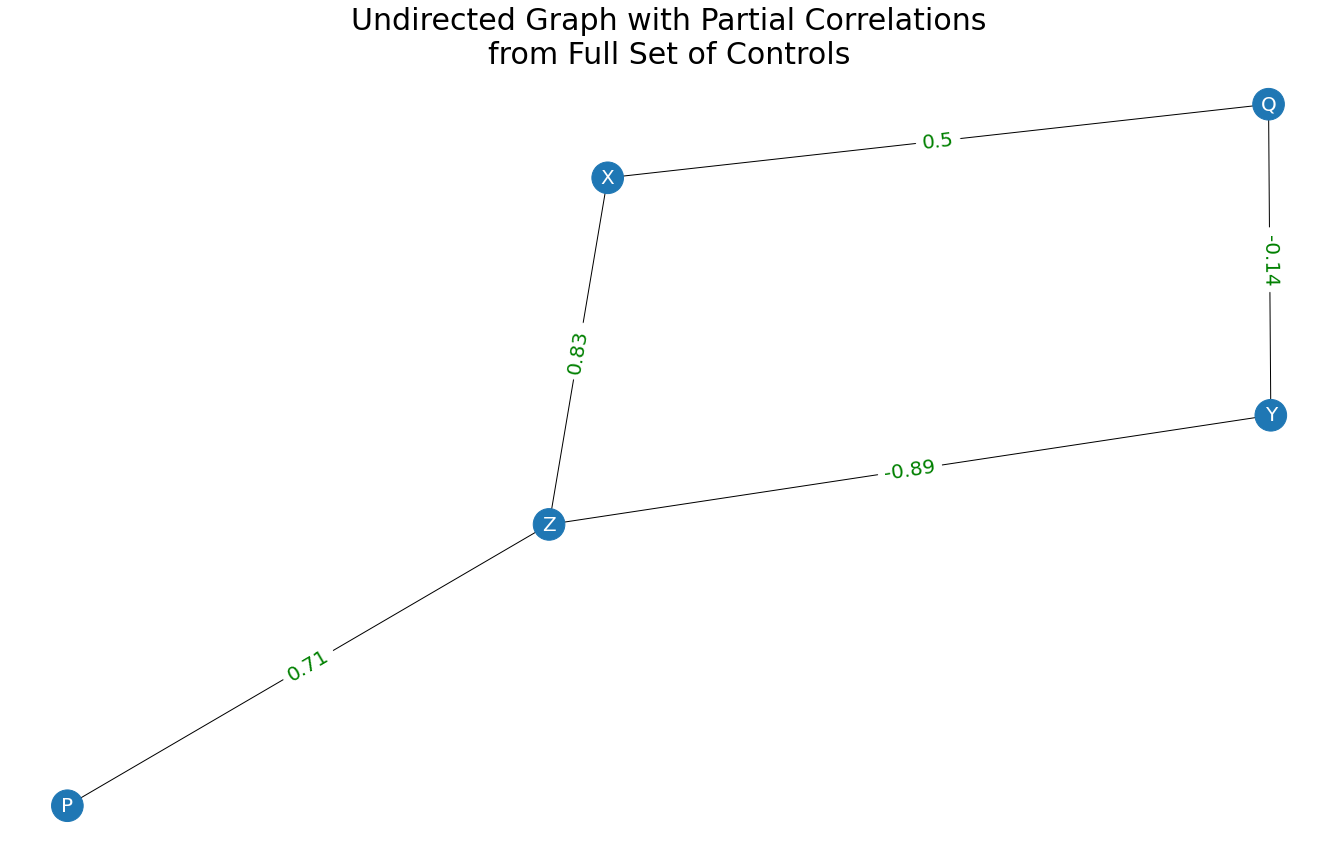

In [14]:
graph_DAG(undirected_graph, df, title = "Undirected Graph with Partial Correlations\nfrom Full Set of Controls")

# Estimating a Directed Acyclic Graph

Now that we have learned to generate the structure of an undirected graph, we have enough familiarity with the concept of a directed acyclc graph (DAG) that we can use the __*pgmpy*__ module to construct a graph with directed edges.\*

We will use the parallel PC algorithm to orient edges. No edge will be left undirected. 

\*A number of different algorithms are used to direct edges. For more information, see the script from [*pgmpy'*s PC algorithm module](https://github.com/pgmpy/pgmpy/blob/dev/pgmpy/estimators/PC.py).

In [15]:
from pgmpy.estimators import PC
c = PC(df)
max_cond_vars = len(df.keys()) - 2


model = c.estimate(return_type = "dag",variant= "parallel",#"orig", "stable"
                   significance_level = p_val, 
                   max_cond_vars = max_cond_vars, ci_test = "pearsonr")
edges = model.edges()


Working for n conditional variables: 3: 100%|████████████████████████████████████████████| 3/3 [00:01<00:00,  1.35it/s]C:\Users\JLCat\anaconda3\lib\site-packages\pgmpy\estimators\PC.py:369: UserWarning: Reached maximum number of allowed conditional variables. Exiting
  warn("Reached maximum number of allowed conditional variables. Exiting")
Working for n conditional variables: 3: 100%|████████████████████████████████████████████| 3/3 [00:02<00:00,  1.30it/s]


OutEdgeView([('X', 'Z'), ('P', 'Z'), ('Y', 'Z'), ('Q', 'X'), ('Q', 'Y')])

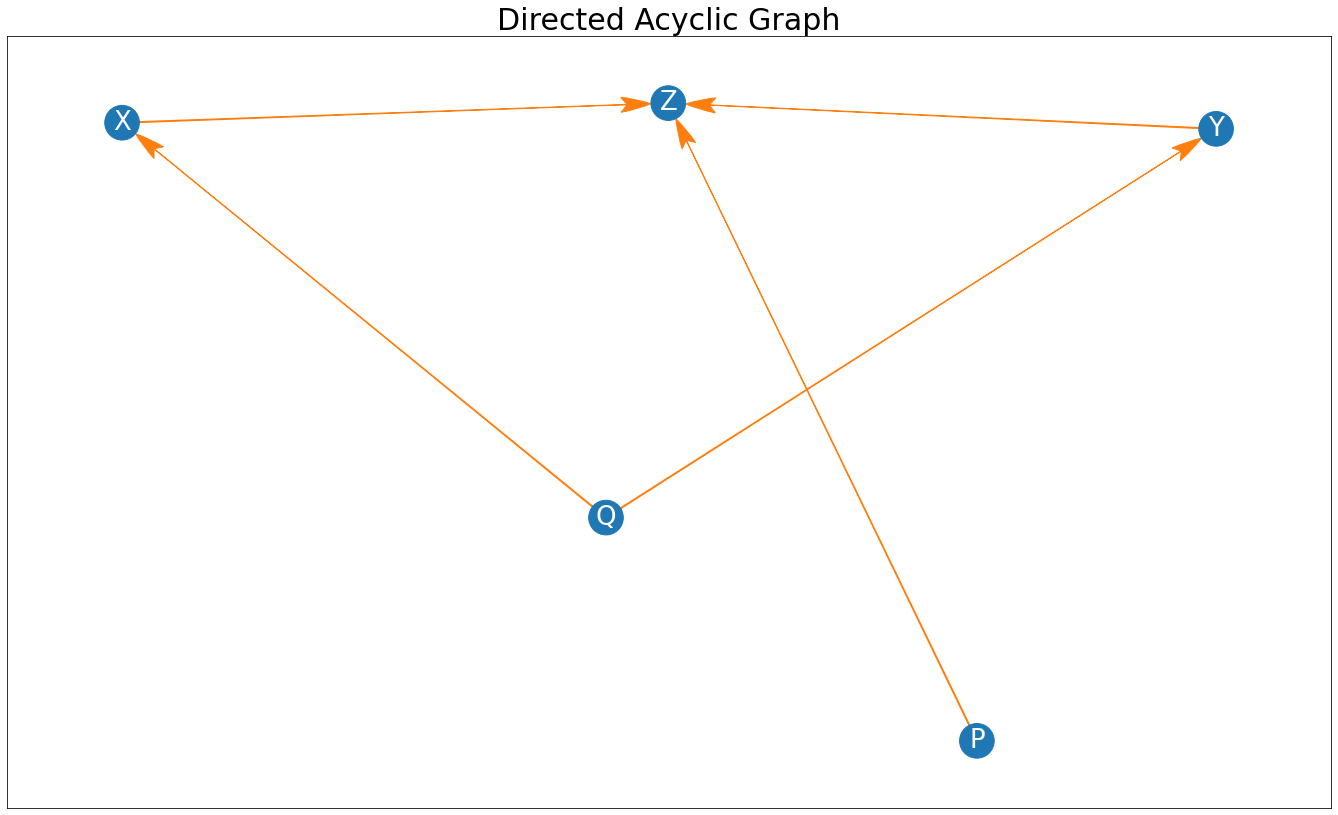

In [16]:
from matplotlib.patches import ArrowStyle

def graph_DAG(edges, df, title = ""):
    graph = nx.DiGraph()
    graph.add_edges_from(edges)
    color_map = ["C0" for g in graph]

    fig, ax = plt.subplots(figsize = (20,12))
    graph.nodes()
    plt.tight_layout()
    pos = nx.spring_layout(graph)#, k = 5/(len(sig_corr.keys())**.5))

    plt.title(title, fontsize = 30)
    nx.draw_networkx(graph, pos, node_color=color_map, node_size = 1200,
                     with_labels=True,  arrows=True,
                     font_color = "white",
                     font_size = 26, alpha = 1,
                     width = 1, edge_color = "C1",
                     arrowstyle=ArrowStyle("Fancy, head_length=3, head_width=1.5, tail_width=.1"), ax = ax)

graph_DAG(edges, df, title = "Directed Acyclic Graph")
edges

### D-separation

Finally, we should control for variables impacting the endogenous variable. For example, if we calculate the partial correlation of $X$ and $Z$ controlling for $Y$, perhaps attempting to estimate the impact of $X$ on $Z$ as defined by $P(Z|X=x, Y)$, we will succeed in removing influence from confound effects of $Q$ on our estimate. An easy way to do this is to identify which node in a pair is a sink node, and to control for all other nodes that directly influence that sink node. If there is no confounding effect from the control, their should be no statisically significan influence on the estimate of the partial correlation. But if the control is influenced by a confounder or is itself a confounder, than controlling for this variable fulfills the requirement of d-separation and the partial correlation should be accurate. Likewise, we do not want to control for variables that do no have influence on the sink-node. For example, it is sufficient to estimate the correlation of $Q$ and $X$ without controlling for any other variables. The estimate is signicantly larger than the partial correlation estimated in the undirected graph.

This exemplifies a problem that commonly arises with the employment of OLS regressions. The addition of exogenous variables to explain the value of a dependent variable can lead to erroneous estimation of marginal effects. As you can see from the distinction between the partial correlations in included in the graphical skeleton as compared to the partial correlations included in the DAG, the effects of $Q$ on $X$ and $Y$ are under estimated due to the inclusion of $Z$. Neither should P be included in this estimation, though its independence from $Q$ should limit its impact on estimation partial correlations of $QX$ and $QY$. We may also note the the partial correlation of $PZ$ is essentially uneffected by inclusion of the other variables since the value of $P$ is generated independently of the remaining variables in the graph. 

keep control: P
keep control: Y
('X', 'Z') ['P', 'Y']
keep control: Y
keep control: X
('P', 'Z') ['Y', 'X']
keep control: P
keep control: X
('Y', 'Z') ['P', 'X']
('Q', 'X') []
('Q', 'Y') []


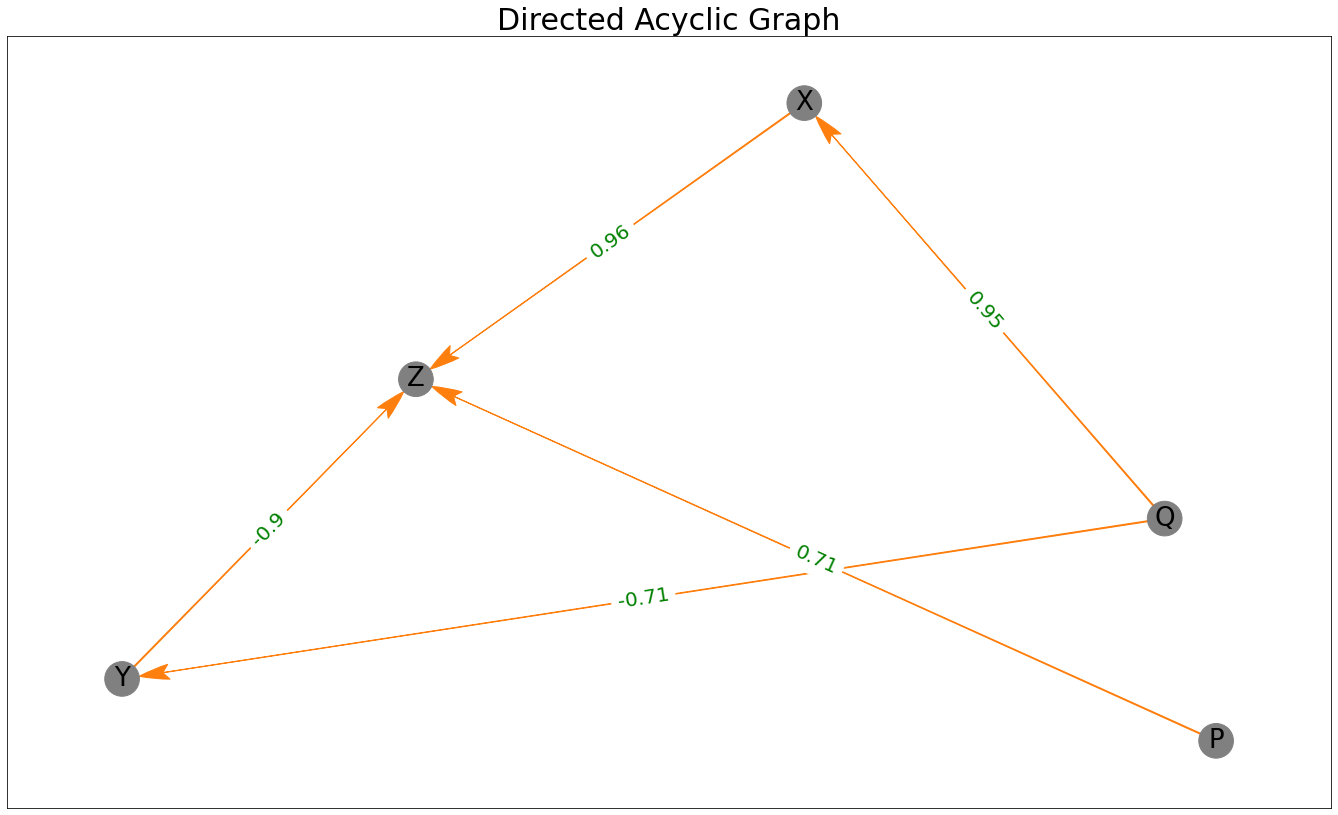

In [17]:
def graph_DAG(edges, df, title = ""):
    graph = nx.DiGraph()
    edge_labels = {}
    ############ Add ############
    for edge in edges:
        controls = [key for key in df.keys() if key not in edge]
        controls = list(set(controls))
        keep_controls = []
        for control in controls:
            control_edges = [ctrl_edge for ctrl_edge in edges if control == ctrl_edge[0] ]
            if (control, edge[1]) in control_edges:
                print("keep control:", control)
                keep_controls.append(control)                
        print(edge, keep_controls)
        pcorr = df[[edge[0], edge[1]]+keep_controls].pcorr()
#         corr_matrix_heatmap(pcorr, save_fig = False, pp = None, title = "Partial Correlation")
        edge_labels[edge] = str(round(pcorr[edge[0]].loc[edge[1]],2))
    graph.add_edges_from(edges)
    color_map = ["grey" for g in graph]

    fig, ax = plt.subplots(figsize = (20,12))
    graph.nodes()
    plt.tight_layout()
    pos = nx.spring_layout(graph)#, k = 5/(len(sig_corr.keys())**.5))

    plt.title(title, fontsize = 30)
    nx.draw_networkx(graph, pos, node_color=color_map, node_size = 1200,
                     with_labels=True,  arrows=True,
                     # turn text black for larger variable names in homework
                     font_color = "k",
                     font_size = 26, alpha = 1,
                     width = 1, edge_color = "C1",
                     arrowstyle=ArrowStyle("Fancy, head_length=3, head_width=1.5, tail_width=.1"), ax = ax)
    ############ Add ############
    nx.draw_networkx_edge_labels(graph,pos,
                                edge_labels=edge_labels,
                                font_color='green',
                                font_size=20)

graph_DAG(edges, df, title = "Directed Acyclic Graph")


# Homework
1. Create a graphical skeleton like the one created above using the Economic Freedom of the World Index and Real GDP. 
2. Create a directed acyclic graph using the same data. Include partial correlations as explained in the **D-Separation** section.

In [18]:
data = pd.read_csv("fraserDataWithRGDPPC.csv", 
                   index_col=[0,1],
                  parse_dates = True).dropna()
years = np.array(sorted(list(set(data.index.get_level_values("Year")))))
years = pd.date_range(years[0], years[-2], freq = "AS")
countries = sorted(list(set(data.index.get_level_values("ISO_Code"))))
index_names = list(data.index.names)
multi_index = pd.MultiIndex.from_product([countries, 
                                          years[:-1]], 
                                         names =data.index.names)
data = data.reindex(multi_index)
data

EFW  Size of Government  \
ISO_Code Year                                       
AGO      1970-01-01       NaN                 NaN   
         1971-01-01       NaN                 NaN   
         1972-01-01       NaN                 NaN   
         1973-01-01       NaN                 NaN   
         1974-01-01       NaN                 NaN   
...                       ...                 ...   
ZWE      2010-01-01  4.374917            6.514112   
         2011-01-01  4.843441            6.424630   
         2012-01-01  4.971192            6.670469   
         2013-01-01  5.246723            6.325105   
         2014-01-01  5.582478            6.433165   

                     Legal System & Property Rights  Sound Money  \
ISO_Code Year                                                      
AGO      1970-01-01                             NaN          NaN   
         1971-01-01                             NaN          NaN   
         1972-01-01                             NaN          NaN   
         1973-01-01                             NaN          NaN   
         1974-01-01                             NaN          NaN   
...                                             ...          ...   
ZWE      2010-01-01                        3.826300     1.972000   
         2011-01-01                        3.943725     4.109198   
         2012-01-01                        4.013004     5.378742   
         2013-01-01                        3.575827     6.895530   
         2014-01-01                        3.615584     7.966798   

                     Freedom to trade internationally  Regulation  \
ISO_Code Year                                                       
AGO      1970-01-01                               NaN         NaN   
         1971-01-01                               NaN         NaN   
         1972-01-01                               NaN         NaN   
         1973-01-01                               NaN         NaN   
         1974-01-01                               NaN         NaN   
...                                               ...         ...   
ZWE      2010-01-01                          4.907822    4.654352   
         2011-01-01                          5.366773    4.372878   
         2012-01-01                          5.132305    3.661438   
         2013-01-01                          5.589087    3.848068   
         2014-01-01                          5.909121    3.987721   

                     RGDP Per Capita  
ISO_Code Year                         
AGO      1970-01-01              NaN  
         1971-01-01              NaN  
         1972-01-01              NaN  
         1973-01-01              NaN  
         1974-01-01              NaN  
...                              ...  
ZWE      2010-01-01           1404.0  
         2011-01-01           1515.0  
         2012-01-01           1604.0  
         2013-01-01           1604.0  
         2014-01-01           1594.0  

[6840 rows x 7 columns]

For these  problems, you will need to consider how to transform real GDP. You could calculate the rate of change of real GDP and leave the index values in their original form. Or after calculating the rate of change of real GDP, you could take the difference of all columns. This is what I elect to do in the next cell.

In [19]:
keys = list(data.keys())[1:]
df = data.copy()[keys]
# df =df[df["RGDP Per Capita"]>10000].diff()
df["RGDP Per Capita"] = data["RGDP Per Capita"].groupby("ISO_Code").pct_change()
df = df.rename(columns={key:key.replace(" ", "\n") for key in df}).dropna()
df = df.groupby("ISO_Code").diff().dropna()
df = df.groupby("ISO_Code").diff().dropna()
df

Size\nof\nGovernment  Legal\nSystem\n&\nProperty\nRights  \
ISO_Code Year                                                                   
AGO      2008-01-01              0.171837                            0.062196   
         2009-01-01              1.729422                           -0.116221   
         2010-01-01             -3.163849                            0.081398   
         2011-01-01              1.462958                           -0.137385   
         2012-01-01             -0.131744                           -0.195420   
...                                   ...                                 ...   
ZWE      2010-01-01             -1.154371                            0.214513   
         2011-01-01              0.766021                            0.000354   
         2012-01-01              0.335321                           -0.048146   
         2013-01-01             -0.591203                           -0.506456   
         2014-01-01              0.453424                            0.476933   

                     Sound\nMoney  Freedom\nto\ntrade\ninternationally  \
ISO_Code Year                                                            
AGO      2008-01-01      0.187381                            -0.383998   
         2009-01-01     -0.374087                             0.551355   
         2010-01-01      0.126545                             0.254118   
         2011-01-01     -0.230442                            -0.357220   
         2012-01-01      0.785161                            -0.089730   
...                           ...                                  ...   
ZWE      2010-01-01      2.463633                            -0.211094   
         2011-01-01      1.112698                             0.417623   
         2012-01-01     -0.867654                            -0.693418   
         2013-01-01      0.247243                             0.691249   
         2014-01-01     -0.445519                            -0.136747   

                     Regulation  RGDP\nPer\nCapita  
ISO_Code Year                                       
AGO      2008-01-01   -0.521390          -0.102206  
         2009-01-01    0.092771          -0.026541  
         2010-01-01    0.890850           0.120507  
         2011-01-01   -1.382188          -0.005091  
         2012-01-01    0.748788           0.007626  
...                         ...                ...  
ZWE      2010-01-01   -0.122065          -0.213089  
         2011-01-01   -0.257004          -0.027885  
         2012-01-01   -0.429966          -0.010157  
         2013-01-01    0.898070          -0.038432  
         2014-01-01   -0.046978           0.052511  

[1990 rows x 6 columns]

In [20]:
def graph_DAG(edges, 
              df, 
              pp=False, 
              edge_labels = False, 
              sig_vals = [.05,.01,.001],
              title = ""):
    def build_edge_labels(edges, df, sig_vals):
        edge_labels = {}
        for edge in edges:
            controls = [key for key in df.keys() if key not in edge]
            controls = list(set(controls))
            keep_controls = []
            for control in controls:
                control_edges = [ctrl_edge for ctrl_edge in edges if control == ctrl_edge[0] ]
                if (control, edge[1]) in control_edges:
                    keep_controls.append(control)                
            pcorr = df.partial_corr(x = edge[0], y = edge[1], covar=keep_controls,
                                  method = "pearson")
            label = str(round(pcorr["r"][0],2))
            pvalue = pcorr["p-val"][0]
#             pcorr = df[[edge[0], edge[1]]+keep_controls].pcorr()
#             label = pcorr[edge[0]].loc[edge[1]]

            for sig_val in sig_vals:
                if pvalue < sig_val: 
                    label = label + "*"   
            
            edge_labels[edge] = label
        return edge_labels
    graph = nx.DiGraph()
    if edge_labels == False:
        edge_labels = build_edge_labels(edges, 
                                        df, 
                                        sig_vals=sig_vals) 
    graph.add_edges_from(edges)
    color_map = ["C0" for g in graph]

    fig, ax = plt.subplots(figsize = (20,20))
    graph.nodes()
    plt.tight_layout()
    pos = nx.spring_layout(graph)#, k = 5/(len(sig_corr.keys())**.5))

    nx.draw_networkx(graph, pos, node_color=color_map, node_size = 2500,
                     with_labels=True,  arrows=True,
                     font_color = "k",
                     font_size = 26, alpha = 1,
                     width = 1, edge_color = "C1",
                     arrowstyle=ArrowStyle("Fancy, head_length=3, head_width=1.5, tail_width=.1"),
                     connectionstyle='arc3, rad = 0.05',
                     ax = ax)
    
    plt.title(title, fontsize = 30)
    edge_labels2 = []
    for u, v, d in graph.edges(data=True):
        if pos[u][0] > pos[v][0]:  
            if (v,u) in edge_labels.keys():
                edge_labels2.append(((u, v,), f'{edge_labels[u,v]}\n\n\n{edge_labels[(v,u)]}'))  
        if (v,u) not in edge_labels.keys():
            edge_labels2.append(((u,v,), f'{edge_labels[(u,v)]}'))
    edge_labels = dict(edge_labels2)

    nx.draw_networkx_edge_labels(graph, 
                                 pos,
                                 edge_labels=edge_labels, 
                                 font_color='C2')
    
    nx.draw_networkx_edge_labels(graph,pos,
                                 edge_labels=edge_labels,
                                 font_color='green',
                                 font_size=20)
    if pp == True:
        pp.savefig(fig, bbox_inches = "tight")  
    plt.show()
    plt.close()

p_val=.3
c = PC(df.dropna())
max_cond_vars = len(df.keys()) - 2
model = c.estimate(return_type = "pdag",
                   variant= "parallel",#"orig", "stable"
                   significance_level = p_val, 
                   max_cond_vars = max_cond_vars, 
                   ci_test = "pearsonr")
edges = model.edges()

Working for n conditional variables: 4: 100%|████████████████████████████████████████████| 4/4 [00:03<00:00,  1.32it/s]C:\Users\JLCat\anaconda3\lib\site-packages\pgmpy\estimators\PC.py:369: UserWarning: Reached maximum number of allowed conditional variables. Exiting
  warn("Reached maximum number of allowed conditional variables. Exiting")
Working for n conditional variables: 4: 100%|████████████████████████████████████████████| 4/4 [00:03<00:00,  1.23it/s]


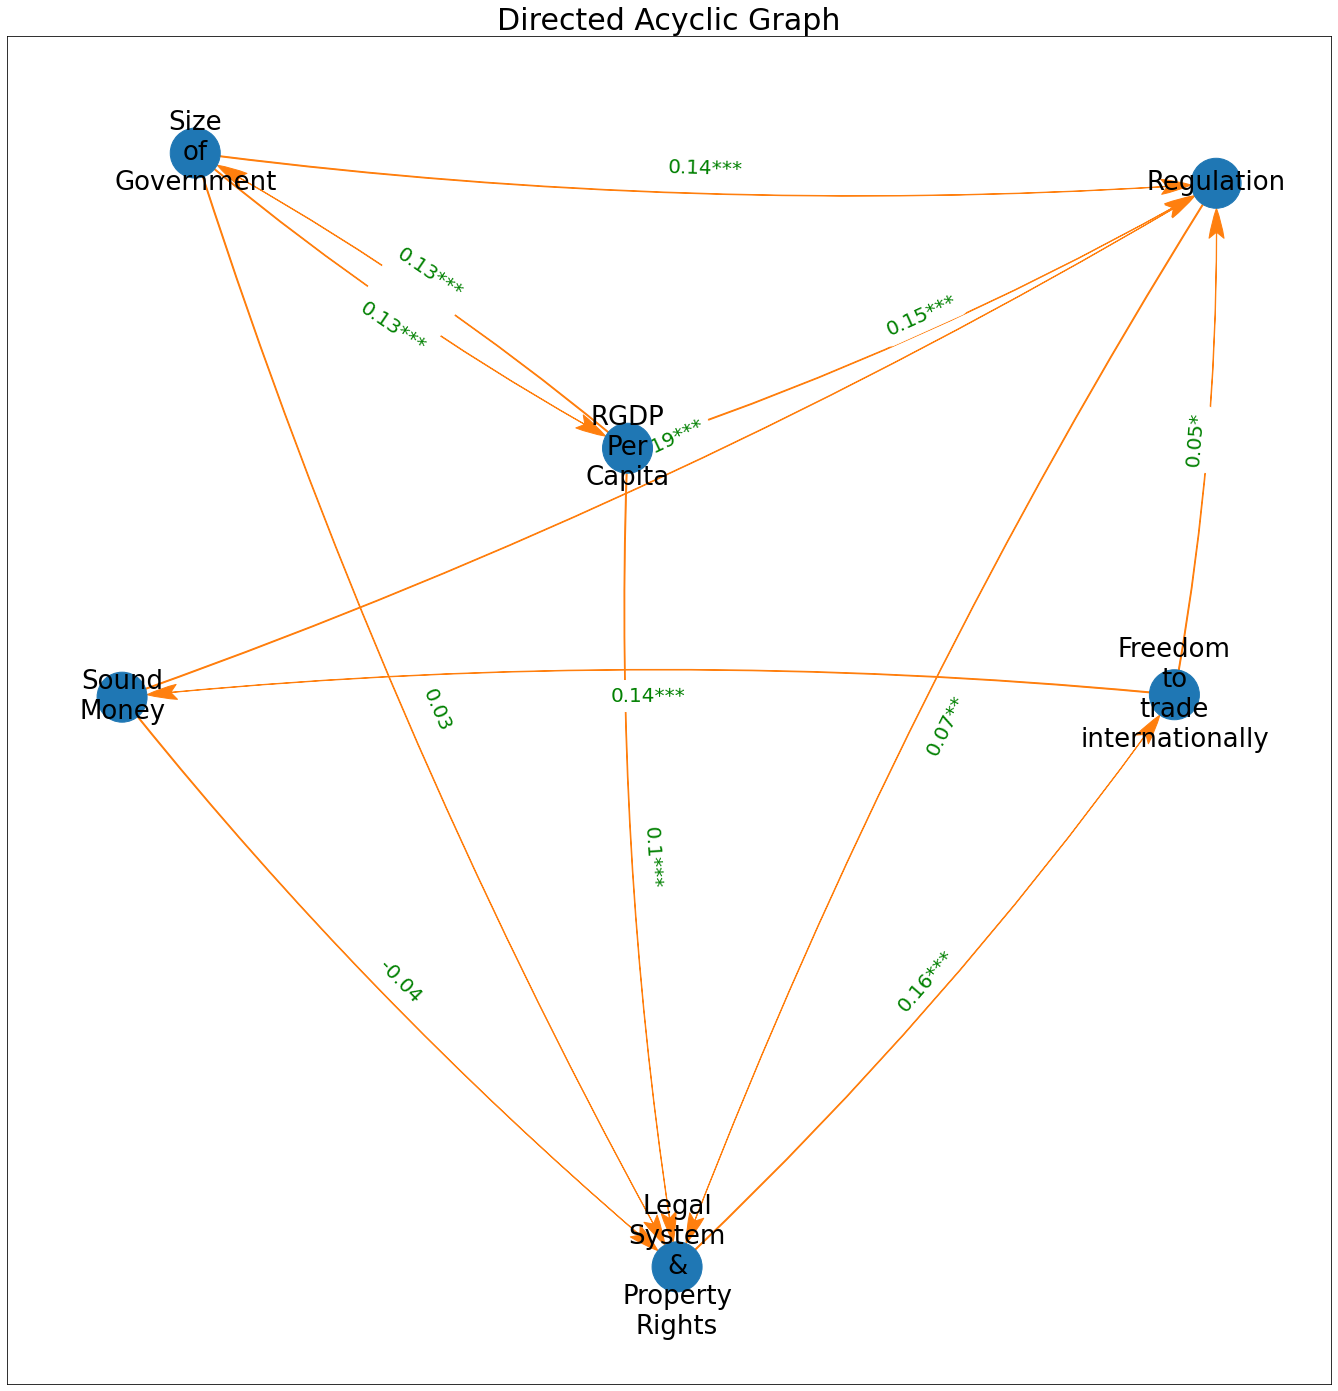

In [21]:
graph_DAG(edges, df, title = "Directed Acyclic Graph")

Working for n conditional variables: 4: 100%|████████████████████████████████████████████| 4/4 [00:02<00:00,  2.10it/s]C:\Users\JLCat\anaconda3\lib\site-packages\pgmpy\estimators\PC.py:369: UserWarning: Reached maximum number of allowed conditional variables. Exiting
  warn("Reached maximum number of allowed conditional variables. Exiting")
Working for n conditional variables: 4: 100%|████████████████████████████████████████████| 4/4 [00:02<00:00,  1.88it/s]


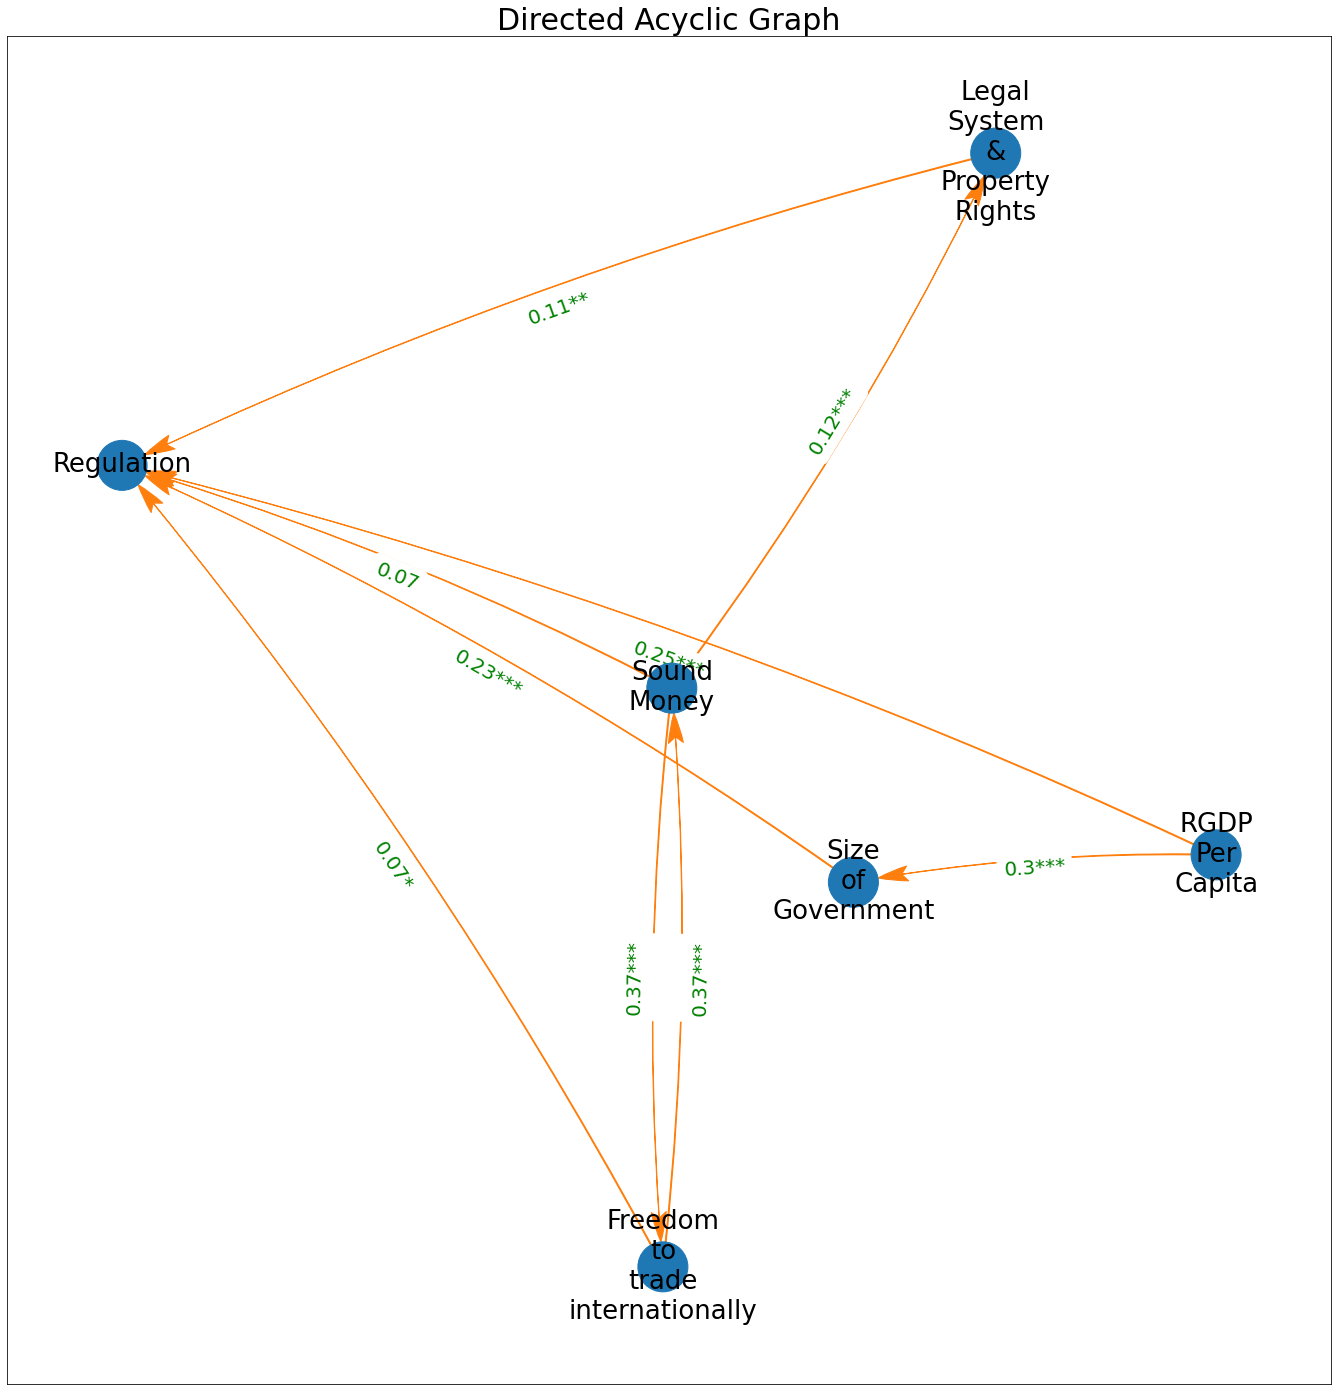

In [22]:
df = data.copy()[keys]
df =df[df["RGDP Per Capita"]>15000]#.diff()
df["RGDP Per Capita"] = df["RGDP Per Capita"].groupby("ISO_Code").pct_change()
# df = df[["RGDP Per Capita", "EFW"]]
df = df.rename(columns={key:key.replace(" ", "\n") for key in df}).dropna()
df = df.groupby("ISO_Code").diff().dropna()
df = df.groupby("ISO_Code").diff().dropna()
c = PC(df.dropna())
max_cond_vars = len(df.keys()) - 2
model = c.estimate(return_type = "pdag",
                   variant= "parallel",#"orig", "stable"
                   significance_level = p_val, 
                   max_cond_vars = max_cond_vars, 
                   ci_test = "pearsonr")
edges = model.edges()
graph_DAG(edges, df, title = "Directed Acyclic Graph")

Working for n conditional variables: 4: 100%|████████████████████████████████████████████| 4/4 [00:03<00:00,  1.16it/s]C:\Users\JLCat\anaconda3\lib\site-packages\pgmpy\estimators\PC.py:369: UserWarning: Reached maximum number of allowed conditional variables. Exiting
  warn("Reached maximum number of allowed conditional variables. Exiting")
Working for n conditional variables: 4: 100%|████████████████████████████████████████████| 4/4 [00:03<00:00,  1.13it/s]


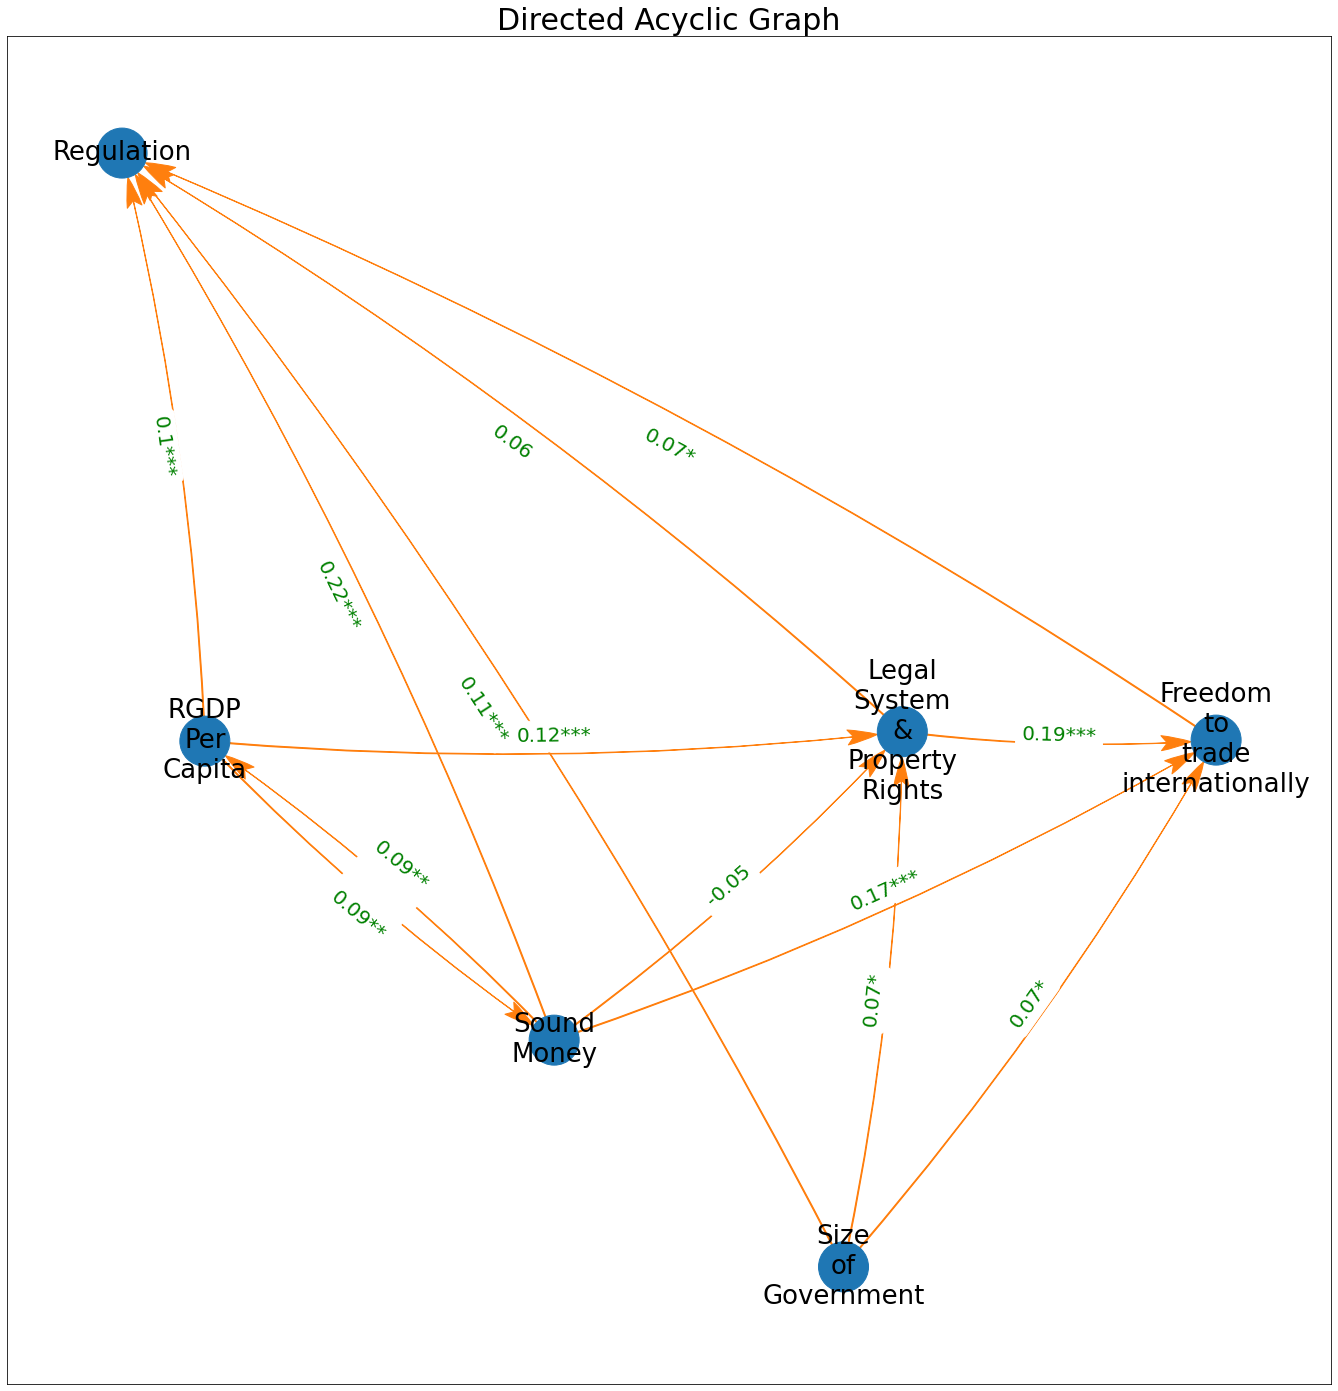

In [23]:
df = data.copy()[keys]
df =df[df["RGDP Per Capita"] < 15000]#.diff()
df["RGDP Per Capita"] = df["RGDP Per Capita"].groupby("ISO_Code").pct_change()
# df = df[["RGDP Per Capita", "EFW"]]
df = df.rename(columns={key:key.replace(" ", "\n") for key in df}).dropna()
df = df.groupby("ISO_Code").diff().dropna()
df = df.groupby("ISO_Code").diff().dropna()
c = PC(df.dropna())
max_cond_vars = len(df.keys()) - 2
model = c.estimate(return_type = "pdag",
                   variant= "parallel",#"orig", "stable"
                   significance_level = p_val, 
                   max_cond_vars = max_cond_vars, 
                   ci_test = "pearsonr")
edges = model.edges()
graph_DAG(edges, df, title = "Directed Acyclic Graph")